In [1]:
import numpy as np
import pandas as pd
import os, sys

import matplotlib.pyplot as plt

import PIL
from PIL import Image, ImageOps
import matplotlib.pylab as plt
%matplotlib inline

import cv2
import ntpath
from pathlib import Path
import asyncio
from tqdm.auto import tqdm
import math

tqdm.pandas()


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
#h = 250
#w = 250
h = 224
w = 224


In [3]:
!ls /kaggle/input/flowers-recognition/flowers/

daisy  dandelion  flowers  rose  sunflower  tulip


In [4]:
basedir = "/kaggle/input/flowers-recognition/flowers"
daisy_dir = f"{basedir}/daisy"
dandelion_dir = f"{basedir}/dandelion"
flowers_dir = f"{basedir}/flowers"
rose_dir = f"{basedir}/rose"
sunflower_dir = f"{basedir}/sunflower"
tulip_dir = f"{basedir}/tulip"


In [5]:
!ls /kaggle/input/flowers-recognition/flowers/dandelion/*.py

/kaggle/input/flowers-recognition/flowers/dandelion/flickr.py
/kaggle/input/flowers-recognition/flowers/dandelion/run_me.py


In [6]:
import glob
daisy_files = glob.glob(f"{daisy_dir}/*.jpg")
dandelion_files = glob.glob(f"{dandelion_dir}/*.jpg")
flowers_files = glob.glob(f"{flowers_dir}/*.jpg")
rose_files = glob.glob(f"{rose_dir}/*.jpg")
sunflower_files = glob.glob(f"{sunflower_dir}/*.jpg")
tulip_files = glob.glob(f"{tulip_dir}/*.jpg")
print(len(daisy_files))
print(len(dandelion_files))
print(len(flowers_files))
print(len(rose_files))
print(len(sunflower_files))
print(len(tulip_files))


769
1052
0
784
734
984


In [7]:
all_filepaths = []
all_filepaths.extend(daisy_files+dandelion_files+flowers_files+rose_files+sunflower_files+tulip_files)
total_files = len(all_filepaths)
total_files


4323

In [8]:
labels = []
labels.extend(["daisy"]*len(daisy_files)+
              ["dandelion"]*len(dandelion_files)+
              ["rose"]*len(rose_files)+
              ["sunflower"]*len(sunflower_files)+
              ["tulip"]*len(tulip_files))
len(labels)

4323

In [9]:
%%time
idx = 0
img_sizes = []
widths = np.zeros(total_files, dtype=int)
heights = np.zeros(total_files, dtype=int)
aspect_ratios = np.zeros(total_files) #defaults to type float
for filename in tqdm(all_filepaths):
    img = PIL.Image.open(f"{filename}")
    img_size = img.size
    img_sizes.append(img_size)
    widths[idx] = img_size[0]
    heights[idx] = img_size[1]
    aspect_ratios[idx] = img_size[0]/img_size[1]
    img.close()
    idx += 1


CPU times: user 1.29 s, sys: 564 ms, total: 1.85 s
Wall time: 10.3 s


In [10]:
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame()
df["filename"] = all_filepaths
df["label"] = labels
label_encoder = LabelEncoder()
df["enc_label"] = label_encoder.fit_transform(df["label"])
df["size"] = img_sizes
df["width"] = widths
df["height"] = heights
df["aspect_ratio"] = aspect_ratios
df.head()

filename  label  enc_label  \
0  /kaggle/input/flowers-recognition/flowers/dais...  daisy          0   
1  /kaggle/input/flowers-recognition/flowers/dais...  daisy          0   
2  /kaggle/input/flowers-recognition/flowers/dais...  daisy          0   
3  /kaggle/input/flowers-recognition/flowers/dais...  daisy          0   
4  /kaggle/input/flowers-recognition/flowers/dais...  daisy          0   

         size  width  height  aspect_ratio  
0  (500, 281)    500     281      1.779359  
1  (240, 217)    240     217      1.105991  
2  (500, 332)    500     332      1.506024  
3  (134, 240)    134     240      0.558333  
4  (320, 221)    320     221      1.447964

In [11]:
%%time

def pil_crop_img(img):
    cropped_img = ImageOps.pad(img, (h, w), centering=(0.5,0.5))
#    plt.imshow(cropped_img)
    
    return cropped_img

def load_images(image_paths, labels, write_to_file=True):
    images = []
    for idx, image_path in tqdm(enumerate(image_paths), total=total_files):
        label = labels[idx]
        img = Image.open(image_path)
        img = pil_crop_img(img)
        if (write_to_file):
            filename = Path(image_path).name
            output_dir = Path(f"{label}")
            output_dir.mkdir(parents=True, exist_ok=True)
            output_path = f"{output_dir}/{filename}"
            img.save(output_path)
            images.append(output_path)
        else:
            #https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/
            img = np.asarray(img)
            images.append(img)
    return images

filenames = load_images(df["filename"], df["label"], True)



#labels = []
#images = load_images(daisy_files, "daisy", labels)
#print(len(images))
#images.extend(load_images(dandelion_files, "dandelion", labels))
#print(len(images))
#images.extend(load_images(rose_files, "rose", labels))
#print(len(images))
#images.extend(load_images(sunflower_files, "sunflower", labels))
#print(len(images))
#images.extend(load_images(tulip_files, "tulip", labels))
#print(len(images))
#print(len(labels))



CPU times: user 40.4 s, sys: 683 ms, total: 41.1 s
Wall time: 42.2 s


In [12]:
df["filename"] = filenames
df.head()

filename  label  enc_label        size  width  \
0    daisy/14716799982_ed6d626a66.jpg  daisy          0  (500, 281)    500   
1   daisy/2520369272_1dcdb5a892_m.jpg  daisy          0  (240, 217)    240   
2     daisy/8681746439_d6beeefbf9.jpg  daisy          0  (500, 332)    500   
3  daisy/34266044490_01dacd2ac2_n.jpg  daisy          0  (134, 240)    134   
4  daisy/13491959645_2cd9df44d6_n.jpg  daisy          0  (320, 221)    320   

   height  aspect_ratio  
0     281      1.779359  
1     217      1.105991  
2     332      1.506024  
3     240      0.558333  
4     221      1.447964

In [13]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

filename      label  enc_label        size  \
0      tulip/14651383746_419dc73634_m.jpg      tulip          4  (147, 240)   
1  sunflower/14925397351_c7f209d804_n.jpg  sunflower          3  (320, 252)   
2    dandelion/17344936845_fec4d626b7.jpg  dandelion          1  (500, 333)   
3      tulip/16568820360_a938311dd3_n.jpg      tulip          4  (240, 159)   
4   sunflower/6606753075_72ee32aa30_m.jpg  sunflower          3  (159, 240)   

   width  height  aspect_ratio  
0    147     240      0.612500  
1    320     252      1.269841  
2    500     333      1.501502  
3    240     159      1.509434  
4    159     240      0.662500

In [14]:
df.describe()

enc_label        width       height  aspect_ratio
count  4323.000000  4323.000000  4323.000000   4323.000000
mean      2.025908   338.229470   252.962063      1.334654
std       1.426520   119.055881    61.601854      0.309799
min       0.000000   134.000000    80.000000      0.558333
25%       1.000000   240.000000   214.000000      1.282570
50%       2.000000   320.000000   240.000000      1.441441
75%       3.000000   500.000000   328.000000      1.502347
max       4.000000  1024.000000   442.000000      5.475936

In [15]:
df_sorted = df.sort_values(by="aspect_ratio")

In [16]:
def plot_first_9(df_to_plot):
    plt.figure(figsize=[30,30])
    for x in range(9):
        filename = df_to_plot.iloc[x].filename
        img = PIL.Image.open(f"{filename}")
        print(filename)
        plt.subplot(3, 3, x+1)
        plt.imshow(img)
        title_str = filename+" "+str(df_to_plot.iloc[x].aspect_ratio)
        plt.title(title_str)

tulip/20742669999_53de71a4c9_n.jpg
tulip/19915714271_3d8d6a23a5_n.jpg
tulip/20876954720_62920b4ce8_n.jpg
tulip/20282921225_6033da8cd5_n.jpg
tulip/19892310888_9bbdec4ea7_n.jpg
tulip/20495079414_44c6783519_n.jpg
tulip/19660257424_e9080d2ddc_n.jpg
tulip/19892369060_d1298a9816_n.jpg
tulip/20929606590_f92d4e59b7_n.jpg


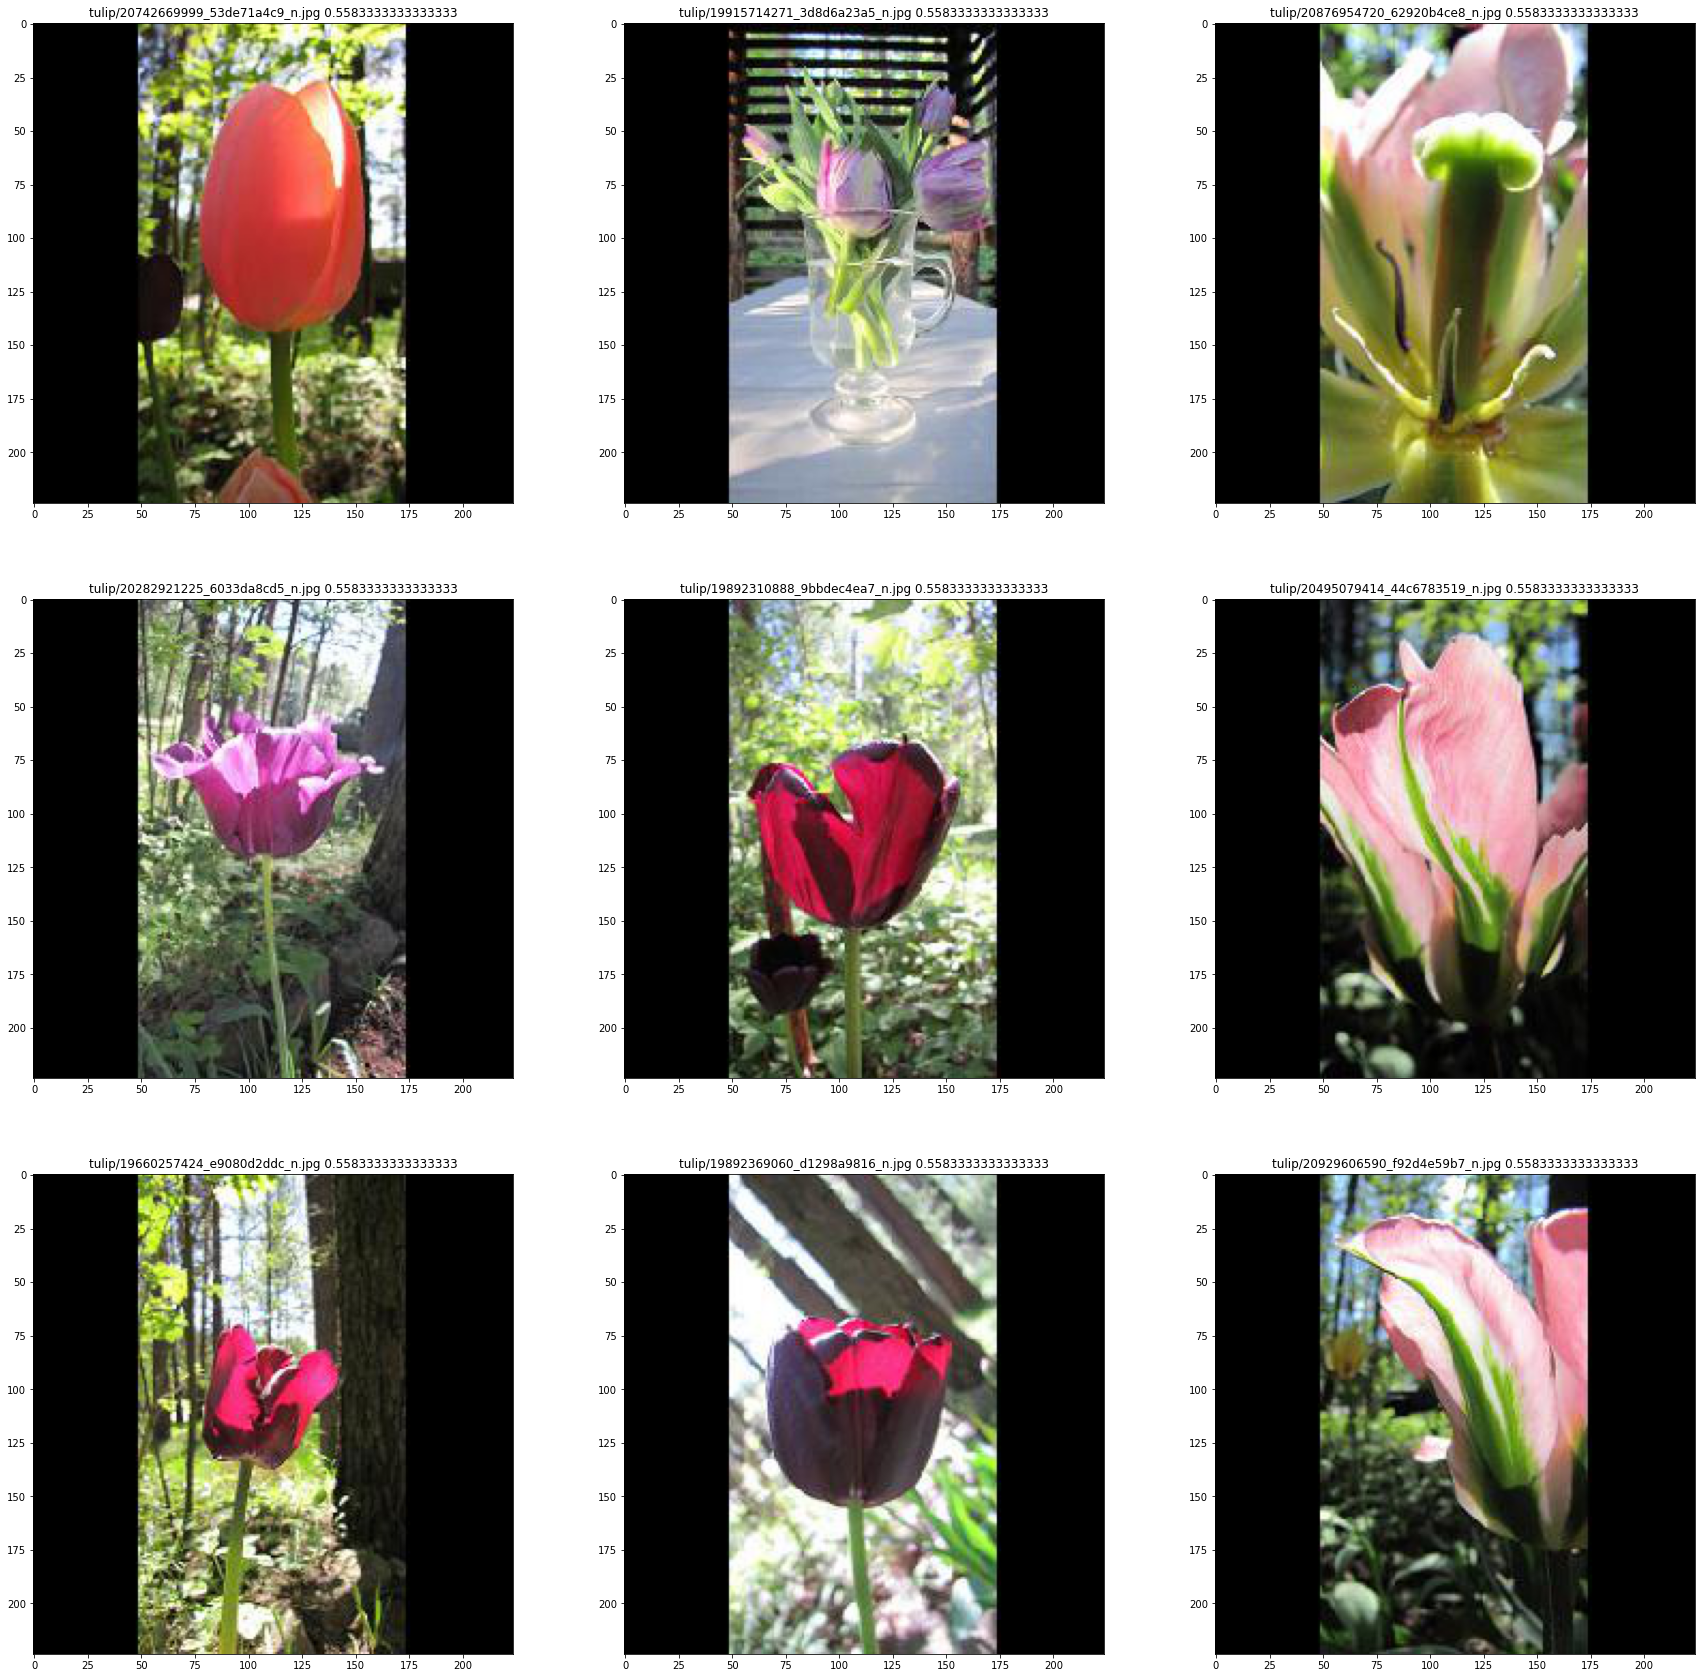

In [17]:
plot_first_9(df_sorted)

In [18]:
df_sorted = df.sort_values(by="aspect_ratio", ascending=False)

tulip/6905876618_12732b74de_b.jpg
tulip/13555215723_cf2c11626b_b.jpg
sunflower/15030133005_9728102622_z.jpg
rose/18302701228_2b5790b199_n.jpg
rose/18302691898_9dc45afae8_n.jpg
tulip/2243427551_809b603992_z.jpg
daisy/4694730335_2553e77aa5_z.jpg
tulip/738207467_fc59cfcd9b_z.jpg
tulip/18270448366_d5676dec64_z.jpg


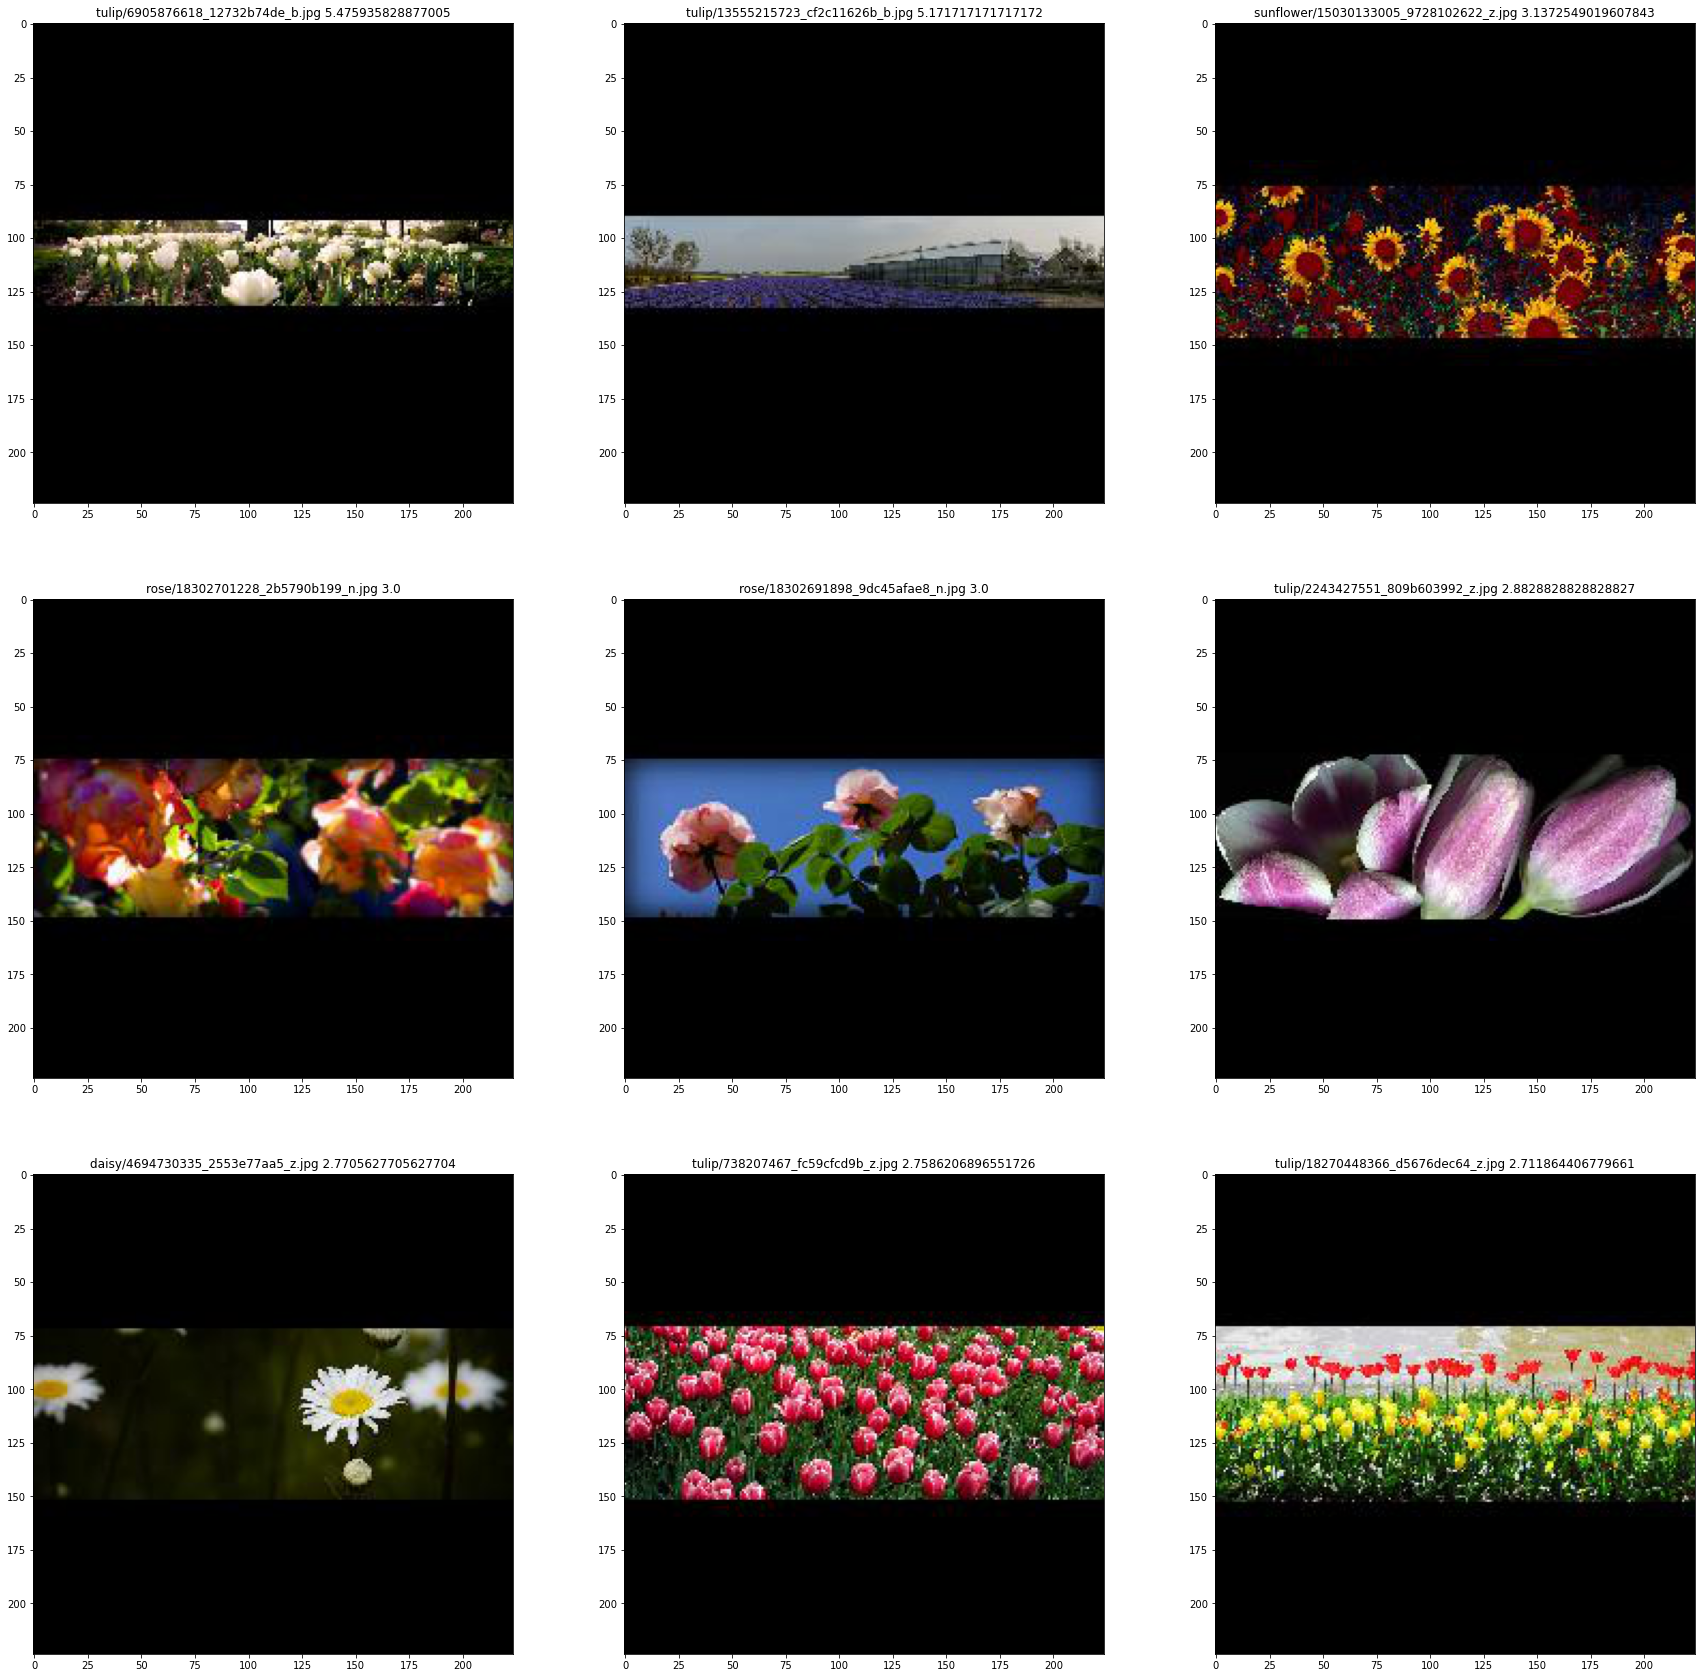

In [19]:
plot_first_9(df_sorted)

In [20]:
async def hello(name):
    print(f"hello {name}")
    async def bob():
        print("bob")
    calls = []
    await bob()
    await bob()
    calls.append(bob())
    calls.append(bob())
    await asyncio.gather(*calls)
    return name

await hello("nnn")

hello nnn
bob
bob
bob
bob


'nnn'

In [21]:
batch_size = 32

In [22]:
model_img_size = 224


In [23]:
from imgaug import augmenters as iaa

def img_augment(img):
    #fifty_chance = lambda aug: iaa.Sometimes(0.5, aug)
    import random
    if random.randint(1,101) > 90:
        #print("original")
        #one in 10 return original image
        return img
    seq = iaa.SomeOf(3, [
        iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        #iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 1.0 TODO: test for good values
        iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            scale=(0.8, 1.2),
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": 0}, # translate by -20 to +20 percent (per axis)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            rotate=(-10, 10), # rotate by -10 to +10 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            shear=(-5, 5), # shear by -5 to +5 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
    ])
    img = seq.augment_image(img)
    return img

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
#https://github.com/aleju/imgaug

In [ ]:
class AugmentationConfig:
    #could also use a generic preprocessing function here
    preprocess_resnet = False
    crop_high_and_wide = False
    augment_probability = 90
    #set to 0 for no random crop. it means to cut this many pixels from side of image
    random_crop_size = 16
    

In [24]:
#TODO: check import tensorflow.keras as keras
from tensorflow.keras.applications import resnet50
import random

def img_pad_resize(df, filename, augment):
    img_meta = df[df["filename"] == filename].iloc[0]
    #print(img_meta)
    img = PIL.Image.open(f'{filename}')

    cropped = False
    if random.randint(1,101) > 50:
        aspect_ratio = img_meta["aspect_ratio"]
        if aspect_ratio > 2 or aspect_ratio < 0.5:
            img_w = img_meta["width"]
            img_h = img_meta["height"]
            diff = abs(img_w-img_h)
            if img_w > img_h:
                shorter = "height"
                larger = "width"
                crop_y = 0
                crop_x = random.randint(0, diff)
            else:
                shorter = "width"
                larger = "height"
                crop_x = 0
                crop_y = random.randint(0, diff)
            crop_size = img_meta[shorter]
            img_cropped = img.crop((crop_x, crop_y, crop_x+crop_size, crop_y+crop_size))
            img.close()
            img = img_cropped
            cropped = True
            #print("cropped:"+filename)
       
    w = img.size[0]
    h = img.size[1]
    pad_size = np.abs(h-w)
    wm = hm = 1
    pw = ph = 0
    if w < h:
        wm = h / w
        pw = pad_size / 2
    else:
        hm = w / h
        ph = pad_size / 2
    w *= wm
    h *= hm
    h = int(h)
    w = int(w)
    pw = int(pw)
    ph = int(ph)
    padding = (pw, ph, pw, ph)
    padded = ImageOps.expand(img, padding)
    resized = padded.resize((model_img_size, model_img_size))
    np_img = np.array(resized)
    img.close()
    padded.close()
    del img
    del padded
    if augment:
        np_img = img_augment(np_img)
    np_img = resnet50.preprocess_input(np_img)
    return np_img

In [25]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a.iloc[p], b[p]

In [53]:
from skimage.io import imread
from skimage.transform import resize
from keras.utils import Sequence

#https://github.com/sdcubber/Keras-Sequence-boilerplate/blob/master/Keras-Sequence.ipynb
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class MySequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, mode="train", augment=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.mode = mode
        self.max_idx = math.ceil(len(x_set)/batch_size)
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx2 = idx % self.max_idx
        start = idx2 * self.batch_size
        end = min(start + batch_size, len(self.x))
        batch_x = self.x.iloc[start : end]
        batch_y = self.y[start : end]
        
        next_batch = []
        for index, row in batch_x.iterrows():
            file_name = row["filename"]
            #file_path = row["path"]
            padded = img_pad_resize(self.x, file_name, self.augment)
            if padded.shape != (model_img_size, model_img_size, 3):
                print(f"shape mismatch {file_name}, {padded.shape}")
                print()
                #the image has alpha channel, drop it
                padded = padded[ :, :, :3]
            
            next_batch.append(padded)
        np_y = np.array(batch_y)
        result = np.array(next_batch), np_y

        #print(result[0].shape)
        return result

    def on_epoch_end(self):
        self.x, self.y = unison_shuffled_copies(self.x, self.y)

In [54]:
df.head()

filename      label  enc_label        size  \
0      tulip/14651383746_419dc73634_m.jpg      tulip          4  (147, 240)   
1  sunflower/14925397351_c7f209d804_n.jpg  sunflower          3  (320, 252)   
2    dandelion/17344936845_fec4d626b7.jpg  dandelion          1  (500, 333)   
3      tulip/16568820360_a938311dd3_n.jpg      tulip          4  (240, 159)   
4   sunflower/6606753075_72ee32aa30_m.jpg  sunflower          3  (159, 240)   

   width  height  aspect_ratio  
0    147     240      0.612500  
1    320     252      1.269841  
2    500     333      1.501502  
3    240     159      1.509434  
4    159     240      0.662500

In [55]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
labels = lb.fit_transform(df["label"])
labels[:5]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]])

In [56]:
from sklearn.model_selection import train_test_split

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
indexes = np.arange(df.shape[0])
train_indices, valid_indices = train_test_split(indexes, test_size=0.10, random_state=8, stratify=df["label"])


In [57]:
train_sub_df = df.iloc[train_indices]
train_sub_y = labels[train_indices]
valid_sub_df = df.iloc[valid_indices]
valid_sub_y = labels[valid_indices]
#train_gen = MySequence(train_sub_df, train_sub_df["breed_label"], batch_size)
#valid_gen = MySequence(valid_sub_df, valid_sub_df["breed_label"], batch_size)
warmup_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=False)
#TODO: remove probability of no augment from generator?
train_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=True)
valid_gen = MySequence(valid_sub_df, valid_sub_y, batch_size, augment=False)

In [58]:
train_gen.max_idx

122

In [59]:
def plot_gen_batch(generator, idx):
    # configure batch size and retrieve one batch of images
    plt.clf() #clears matplotlib data and axes
    #for batch in train_generator:
    rows = (batch_size / 3)+1
    plt.figure(figsize=[30,10*rows])
    batch = generator.__getitem__(idx)
    print(f"showing {len(batch[0])} images")
    #have to use len(batch[0] here, as batch size can vary if it is the last part of the images (truncated to dataset length)
    for x in range(0, len(batch[0])):
    #    print(train_generator.filenames[x])
        plt.subplot(rows, 3, x+1)
        plt.imshow(batch[0][x], interpolation='nearest')

        diagnosis = batch[1][x]
        print(diagnosis)

    plt.show()

showing 32 images
[0 0 1 0 0]
[1 0 0 0 0]
[0 1 0 0 0]
[0 0 0 1 0]
[0 0 1 0 0]
[0 1 0 0 0]
[0 0 0 1 0]
[0 0 0 1 0]
[0 0 0 0 1]
[0 0 1 0 0]
[0 0 0 1 0]
[0 1 0 0 0]
[0 0 0 1 0]
[0 0 0 1 0]
[1 0 0 0 0]
[0 0 0 0 1]
[0 0 0 1 0]
[0 0 1 0 0]
[0 0 0 0 1]
[0 0 0 1 0]
[0 0 0 0 1]
[0 0 0 1 0]
[0 0 0 1 0]
[1 0 0 0 0]
[0 0 0 0 1]
[0 0 1 0 0]
[0 1 0 0 0]
[0 1 0 0 0]
[0 1 0 0 0]
[0 0 1 0 0]
[0 0 0 0 1]
[0 0 1 0 0]


<Figure size 432x288 with 0 Axes>

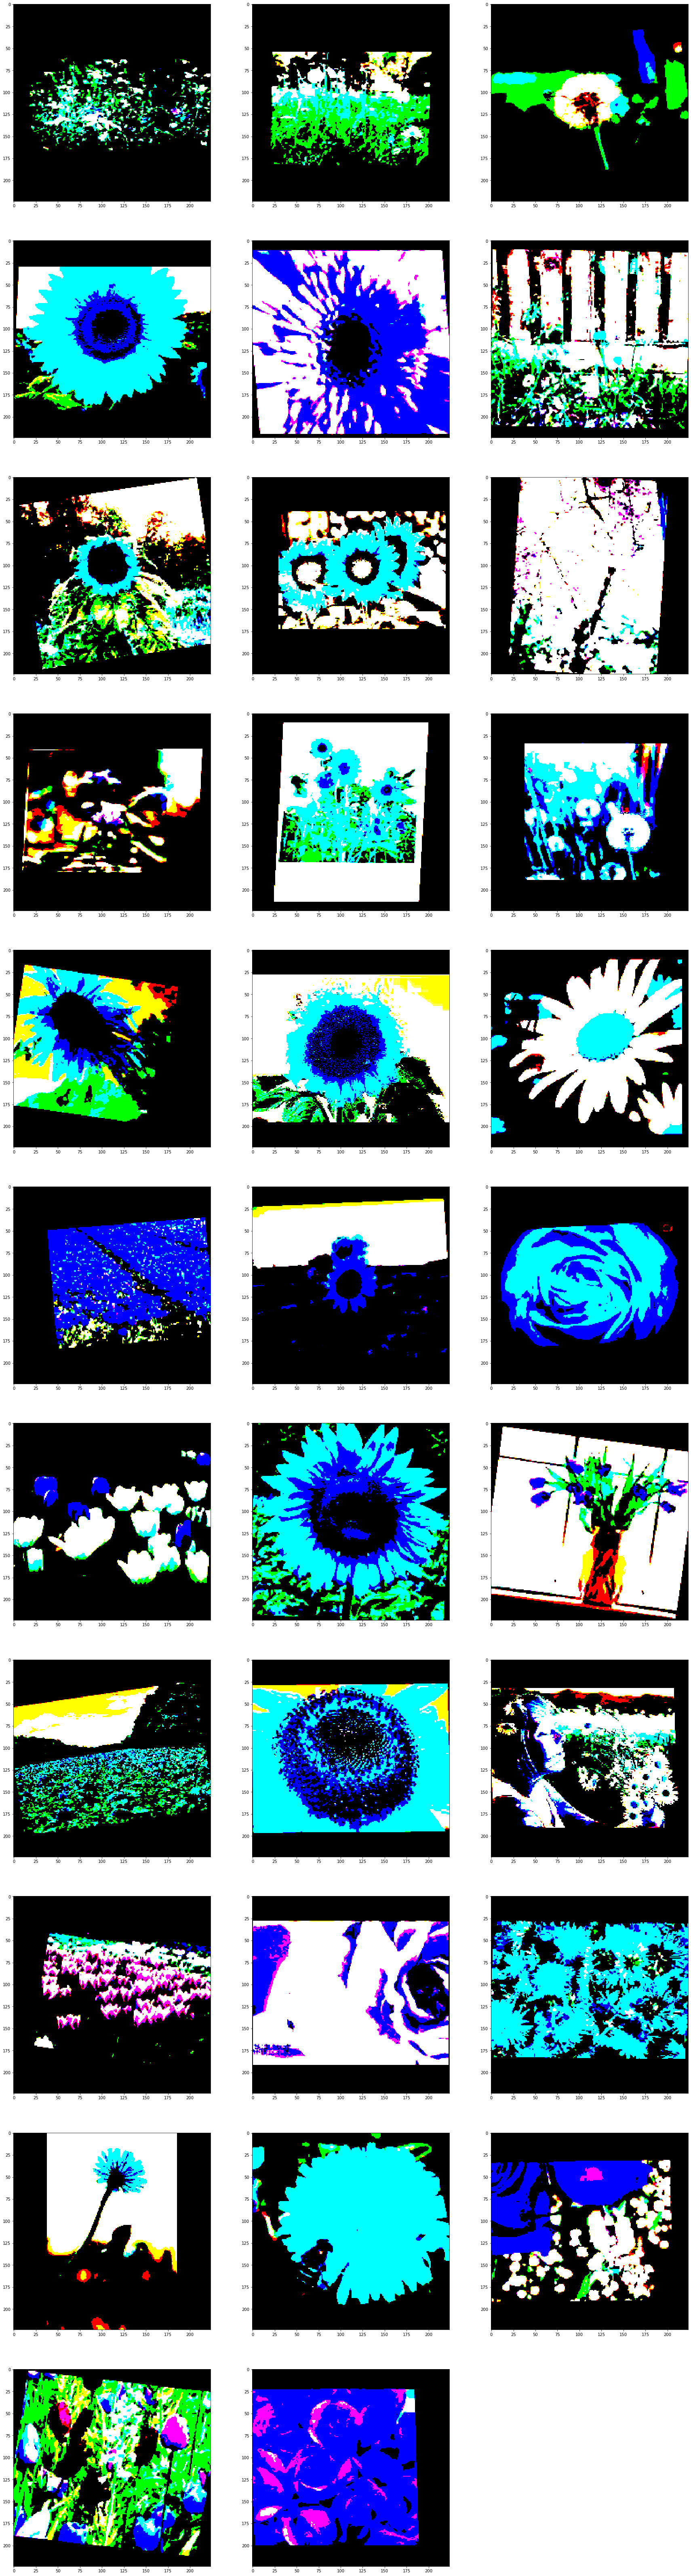

In [64]:
plot_gen_batch(train_gen, 0)

In [ ]:
plot_first_9(df)

In [ ]:
plot_batch_9(valid_generator)

In [ ]:
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Sequential
import matplotlib.pylab as plt

In [ ]:
batch_size = 32
num_classes = 5
epochs = 30
input_shape = (h, w, 3)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
from tensorflow.keras import regularizers

reg = 0.0001

model = Sequential()

model.add(Conv2D(8, (3, 3), input_shape=input_shape, padding='same',
        kernel_regularizer=regularizers.l2(reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(16, (3, 3), input_shape=input_shape, padding='same',
        kernel_regularizer=regularizers.l2(reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16, kernel_regularizer=regularizers.l2(reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='SGD',metrics=['accuracy'])

In [ ]:
import tensorflow

model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Conv2D(128,kernel_size=(3,3) ,activation='relu' , input_shape = input_shape ),
    tensorflow.keras.layers.MaxPool2D(4,4),
    tensorflow.keras.layers.Dropout(rate=0.3),
    tensorflow.keras.layers.Conv2D(512,kernel_size=(3,3),activation='relu'),
    
    tensorflow.keras.layers.MaxPool2D(4,4),
    tensorflow.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    tensorflow.keras.layers.Dropout(rate=0.3),
    tensorflow.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
   
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(512,activation='relu'),
    tensorflow.keras.layers.Dense(128,activation='relu'),
    tensorflow.keras.layers.Dropout(rate=0.5),
    tensorflow.keras.layers.Dense(64,activation='relu'),
    tensorflow.keras.layers.Dense(5,activation='softmax')
])

In [ ]:
adam = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=adam,  #keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)


In [ ]:
#the total number of images we have:
train_size = len(train_generator.filenames)
#train_steps is how many steps per epoch Keras runs the genrator. One step is batch_size*images
train_steps = train_size/batch_size
#use 2* number of images to get more augmentations in. some do, some dont. up to you
train_steps = int(train_steps) #2* seems to break this?
#same for the validation set
valid_size = len(valid_generator.filenames)
valid_steps = valid_size/batch_size
valid_steps = int(valid_steps) #again, no 2*?

In [ ]:
valid_size

In [ ]:
valid_steps

In [ ]:
valid_steps*batch_size

In [ ]:
# create callbacks list
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
from sklearn.model_selection import train_test_split


checkpoint = ModelCheckpoint('../working/cnn_best.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=22)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

callbacks_list = [checkpoint, csv_logger, early]

In [ ]:
train_generator.reset()
valid_generator.reset()
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs = epochs,
        validation_data=valid_generator,
        validation_steps=valid_steps,
        callbacks=callbacks_list,
    verbose = 1
)
#this would load the best scoring weights from above for prediction
model.load_weights("../working/cnn_best.h5")

In [ ]:
pd.DataFrame(fit_history.history).head(20)

In [1]:
def plot_loss_and_accuracy(fit_history):
    plt.clf()
    plt.plot(fit_history.history['accuracy'])
    plt.plot(fit_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    # summarize history for loss
    plt.plot(fit_history.history['loss'])
    plt.plot(fit_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
plot_loss_and_accuracy(fit_history)

In [ ]:
!ls ../working

In [ ]:
!ls /

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
train_generator, valid_generator, train_datagen = \
    create_generators(validation_perc=0.2, shuffle=True, horizontal_flip=True,
                      zoom_range=0.2, w_shift=0.2, h_shift=0.2, rotation_range=0.2, shear_range=0.2,
                      fill_zeros=True, preprocess_func=preprocess_input)

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from tensorflow.keras.applications.resnet50 import ResNet50

def create_resnet_model(trainable_layer_count):
    input_tensor = Input(shape=(w, h, 3))
    base_model = ResNet50(include_top=False,
                          #the weights value can apparently also be a file path..
                   weights=None, #loading weights from dataset, avoiding need for internet conn
                   input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if trainable_layer_count == "all":
        #the full pre-trained model is fine-tuned in this case
        for layer in base_model.layers:
            layer.trainable = True
    else:
        #if not all should be trainable, first set them all as non-trainable (fixed)
        for layer in base_model.layers:
            layer.trainable = False
        #and finally set the last N layers as trainable
        #idea is to re-use higher level features and fine-tune the finer details
        for layer in base_model.layers[-trainable_layer_count:]:
            layer.trainable = True
    print("base model has {} layers".format(len(base_model.layers)))
    #here on it is the fully custom classification on top of pre-trained layers above
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
    x = Dropout(0.5)(x)
    final_output = Dense(5,activation='softmax')(x)
    #doing binary prediction, so just 1 neuron is enough
    #final_output = Dense(1, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [ ]:
resnet_model = create_resnet_model("all")

In [ ]:
checkpoint = ModelCheckpoint('../working/Resnet50_best.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
callbacks_list = [checkpoint, csv_logger, early]

In [ ]:
adam = tensorflow.keras.optimizers.Adam(lr=0.001)

resnet_model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=adam,  #keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [ ]:
train_generator.reset()
valid_generator.reset()
fit_history = resnet_model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs = epochs,
        validation_data=valid_generator,
        validation_steps=valid_steps,
        callbacks=callbacks_list,
    verbose = 1
)
#this would load the best scoring weights from above for prediction
resnet_model.load_weights("../working/Resnet50_best.h5")

In [ ]:
pd.DataFrame(fit_history.history).head(20)

In [ ]:
plot_loss_and_accuracy(fit_history)